# Figure 3

**Figure 3 | Spearman correlation strength of sEEG to simulated LFP.** (A) Bottom-up sensory input model similarity to neural signals. sEEG electrode color intensity represents the similarity of the neural signal to the LFP simulated from the bottom-up model. Similarity is quantified as the absolute value of the median Spearman coefficient (ρ) across all included trials. Similarity is z-scored across n = 7 participants. Electrode size represents the FDR corrected p-value from a 1000-fold permutation test. (B) Similarity values differed between models and controls across all highly significant (p < 0.001, permutation test) cortical electrodes (Friedman test: p = 0.018). Post-hoc, the bottom-up model was significantly less similar to sEEG than the audio envelope ($\rho_{bottom-up}$ median (Q1, Q3) = 0.026 (0.015, 0.038); $\rho_{control}$ = 0.026 (0.012, 0.048); n = 364; two-sided Wilcoxon signed-rank test: $p_{adj}$ < $10^{-5}$). (C) Top-down bias model similarity to neural signals. (D) Post-hoc, the top-down model was significantly more similar to sEEG than the audio envelope ($\rho_{top-down}$ = 0.028 (0.014, 0.050); $\rho_{control}$ = 0.018 (0.008, 0.034); n = 350; two-sided Wilcoxon signed-rank test: $p_{adj}$ < $10^{-5}$). (E) Dynamical systems SAMy (y-unit) model similarity to neural signals. (F) Post-hoc, SAMy had significantly higher similarity values than the audio envelope control condition ($\rho_{SAMy}$ = 0.034 (0.017, 0.061); $\rho_{control}$ = 0.022 (0.010, 0.041); n = 449; two-sided Wilcoxon signed-rank test: $p_{adj}$ < $10^{-5}$). SAMy had higher similarity values than both the top-down model ($\rho_{SAMy}$ = 0.034 (0.017, 0.061), $n_{SAMy}$ = 449; $\rho_{bottom-up}$ = 0.028 (0.014, 0.050), $n_{top-down}$ = 350; two-sided Wilcoxon signed-rank test: $p_{adj}$ = 0.003) and the bottom-up model ($\rho_{SAMy}$ = 0.034 (0.017, 0.061), $n_{SAMy}$ = 449; $\rho_{bottom-up}$ = 0.026 (0.015, 0.038), $n_{bottom-up}$ = 364; two-sided Wilcoxon signed rank test: $p_{adj}$ < $10^{-5}$). (G) Similarity values of highly significant (p < 0.001) electrodes by cortical region. Absolute value of the median $\rho$ coefficient is plotted by cortical region, based on a coarse regional atlas. Horizontal black bars represent region-wise medians. Statistics for within-region model comparisons are available in Table 1. See Supp. Fig. 1 for paired plots of model and control similarity values at the same electrode. All p-values are adjusted for multiple comparisons with a Holm-Bonferroni correction. Stars indicate significant differences between models within a region (∗ p < 0.05, ∗∗ p < 0.01, ∗∗∗ p < 0.001). All participants had sEEG coverage in the prefrontal and superior temporal cortex, but sEEG from other regions represents a subset of participants.


### imports

In [1]:
import numpy as np
import pandas as pd

import mne
from scipy.stats import zscore, false_discovery_control
from pingouin import multicomp, friedman, mwu, wilcoxon

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

### plotting functions

In [7]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def classify_pval(val):
    """classify p-value for sensor size"""
    if val > 0.05:
        return 0.5
    elif 0.001 < val <= 0.05:
        return 0.85
    elif val <= 0.001:
        return 1.25

def load_fif_epo(subj):
    """load iEEG epo.fif file
    
    Parameters:
    -----------
    subj : str
        subject ID number        
    Returns:
    --------
    epo : object
        instance of MNE Epochs 
    """
    
    path = '../../00-data/simulated_sEEG/sim/'+subj+'_sim_epo.fif' 
    epo = mne.read_epochs(path, preload=True)
    
    return epo

def plot_brain_model_fits(patients, SDids, metric, hemi, view):
    """Plots electrode locations from all iEEG recording onto single template brain
    NO NORMALIZATION per subject
    
    Paramters:
    ----------
    patients : list
        list of patient IDs to be plotted
    SDids : list
        list of strings of patient IDs from UCSD Health
    metric : str
        metric to plot or None
    hemi : str
        hemisphere to plot, "left" or "right"
    view : str
        view to plot, "medial" or "lateral"
    
        
    """
    subjects_dir = '../../00-data/freesurfer' # not included in 00-data
    
    # make brain surface
    brain = mne.viz.Brain(
            'fsaverage',
            title = 'Median '+metric+', n='+str(len(SDids)),
            hemi = 'both',
            surf='pial',
            subjects_dir=subjects_dir,
            cortex="low_contrast",
            alpha=0.2,
            background="white",
            units = 'm'
        )

    # load median model fits & pvals
    pval_dfs = []
    for patient in patients:
        pval_path = '../../03-results/perm_test/p_vals/'+patient+'_pvals.csv' 
        pval_df = pd.read_csv(pval_path)
        pval_df['patient'] = np.tile(patient, len(pval_df))
        pval_dfs.append(pval_df)

    all_pval_df = pd.concat(pval_dfs)

    # zscore metric across all patients
    all_pval_df[metric+'_zscore'] = zscore(abs(all_pval_df[metric].values))
    
    # loop through patients and add sensors (color code for metric value)
    for patient, SDid in zip(patients, SDids):

        # load epochs object for one patient
        epochs = load_fif_epo(patient)
        epochs = epochs.pick_types(seeg=True)
        epochs = epochs.drop_channels(epochs.info['bads'])

        # load similarity metrics for one patient
        model_path = '../../03-results/model_comparison/subj_'+patient+'_model_comparison.csv' 
        df = pd.read_csv(model_path) 

        subject = 'FSURF_'+SDid

        # channel locations
        montage = epochs.get_montage()
        ch_names = montage.ch_names
        ch_pos = montage.get_positions()['ch_pos'].values()
        ch_pos = list(ch_pos)
        ch_pos_new = [pos/1000 for pos in ch_pos] # adjust to meter scaling from mm

        # identify hemisphere from channel name
        ch_names_hemi = ['right' if (name[0]=='R') or (name[0]=='D') else 'left' for name in ch_names]
        ch_names_right = np.array(ch_names)[np.array([hemi=='right' for hemi in ch_names_hemi])]
        ch_names_left = np.array(ch_names)[np.array([hemi=='left' for hemi in ch_names_hemi])]
        
        if metric == 'None':
            vals = None
        else:
            # create df with median values across all channels
            median_df = pd.DataFrame(df.groupby('channel', sort=False, as_index=False)[metric].median())
            
            # get this patient's chunk of model dataframe
            subj_pval_df = all_pval_df[all_pval_df['patient']==patient][['channel', metric+'_pval', metric+'_zscore']]

            # FDR correction
            subj_pval_df['FDR_pval'] = false_discovery_control(subj_pval_df[metric+'_pval'].values, method='bh')

            # merge & compute sensor size factors
            median_df = pd.merge(median_df, subj_pval_df, how='left', on='channel')
            median_df['size_factor'] = median_df['FDR_pval'].apply(classify_pval)
            
            # select data from desired hemisphere
            if hemi=='right':
                median_df = median_df[median_df['channel'].isin(ch_names_right)]
                #vals = median_df[metric+'_normalized'].values
                vals = median_df[metric+'_zscore'].values
            elif hemi=='left':
                median_df = median_df[median_df['channel'].isin(ch_names_left)]
                #vals = median_df[metric+'_normalized'].values
                vals = median_df[metric+'_zscore'].values
                
        if len(vals)==0:
            continue
        else:
            if metric == 'raw_SAM_y_rho':
                colors = [cm.RdPu(i) for i in NormalizeData(vals)]
            elif metric == 'raw_top_rho':
                colors = [cm.OrRd(i) for i in NormalizeData(vals)]
            elif metric == 'raw_btm_rho':
                colors = [cm.Blues(i) for i in NormalizeData(vals)]
            elif metric == 'raw_SAM_i_rho':
                colors = [cm.Greens(i) for i in NormalizeData(vals)]
            elif metric == 'raw_SAM_e_rho':
                colors = [cm.YlOrBr(i) for i in NormalizeData(vals)]
            elif metric == 'None':
                colors = 'black'
            else:
                print('metric is '+metric)
                colors = [cm.viridis(i) for i in NormalizeData(vals)]
        
        features = ['raw_top_r', 'raw_top_rho',
            'raw_btm_r', 'raw_btm_rho', 
            'raw_comb_r', 'raw_comb_rho',
            'raw_SAM_y_r', 'raw_SAM_y_rho',
            'raw_SAM_e_r', 'raw_SAM_e_rho', 
            'raw_SAM_i_r', 'raw_SAM_i_rho']

    
        if patient == '1014':
            ch_pos_new = np.asarray(ch_pos_new)
            ch_pos_new[:,0] = ch_pos_new[:,0]+0.006
            ch_pos_new = ch_pos_new*0.92
            
            new_montage = mne.channels.make_dig_montage(dict(zip(ch_names, ch_pos_new)), coord_frame='mri')
            new_montage.add_estimated_fiducials(subject, subjects_dir)
            
            
        else:
        
            new_montage = mne.channels.make_dig_montage(dict(zip(ch_names, ch_pos_new)), coord_frame='mri')
            new_montage.add_estimated_fiducials(subject, subjects_dir)
    
            # Taliarach transform in FSURF_ folder
            mri_mni_t = mne.read_talxfm(subject, subjects_dir)
            new_montage.apply_trans(mri_mni_t)  # mri to mni_tal (MNI Taliarach)
    
            # transform to fsaverage
            new_montage.apply_trans(mne.transforms.Transform(fro="mni_tal", to="mri", trans=np.eye(4)))
        
        
        epochs.set_montage(new_montage)

        # exclude channels from other hemisphere
        if len(ch_names_right)==0:
            pass
        if len(ch_names_left)==0:
            continue
        else:
            if hemi == 'right':
                epochs.pick(list(ch_names_right))
            elif hemi=='left':
                epochs.pick(list(ch_names_left))
            else:
                print('hemi must be "left" or "right"') 
        
        trans = mne.channels.compute_native_head_t(new_montage)
                
        # plot projected channels on fsaverage
        brain.add_sensors(epochs.info, trans=trans, sensor_colors=colors, sensor_scales=0.003*median_df['size_factor'].values) #*median_df['size_factor'].values

    lh = list(brain.plotter.actors.keys())[0]
    rh = list(brain.plotter.actors.keys())[1]

    
    
    if (hemi == 'right') & (view == 'lateral'):
        brain.plotter.remove_actor(lh)
        brain.show_view(azimuth=0)
    elif (hemi == 'right') & (view == 'medial'):
        brain.plotter.remove_actor(lh)
        brain.show_view(azimuth=180, distance=0.38)
    elif (hemi == 'left') & (view == 'lateral'):
        brain.plotter.remove_actor(rh)
        brain.show_view(azimuth=180)
    elif (hemi == 'left') & (view == 'medial'):
        brain.plotter.remove_actor(rh)
        brain.show_view(azimuth=0, distance=0.38)
        
    # save image
    # brain.save_image()
        
     
def plot_regionwise_model_similarity(df):
    sns.set_context('talk')
    plt.figure(figsize=[20,8])

    colors = ['dodgerblue', 'salmon', 'mediumvioletred','slategray']
    scatter_colors = ['white', 'white', 'white', 'white']
    labels = ['bottom-up', 'top-down', r'SAM$_y$', 'audio envelope \n(control)']
    model_order = ['raw_btm_rho', 'raw_top_rho', 'raw_SAM_y_rho', 'control_rho']

    region_order = ['Prefrontal', 'Cingulate', 'Orbitofrontal',  'Rolandic',
                    'MedialWall', 'SuperiorTemporal-Insula', 'LateralTemporal',
                    'Parietal', 'VentralTemporal']

    # df = reorg_df_sig_limctrl
    ax = sns.stripplot(data=df, x='X10', y='rho', hue='model', palette=colors, dodge=True, alpha=0.5,
                       linewidth=0, size=10, order=region_order, hue_order=model_order)

    # plot the mean line
    sns.boxplot(showmeans=True,
                meanline=True,
                meanprops={'visible': False},
                medianprops={'color': 'k', 'ls': '-', 'lw': 2},
                whiskerprops={'visible': False},
                zorder=10,
                x="X10",
                y="rho",
                hue = 'model',
                order = region_order,
                hue_order = model_order,
                data=df,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=ax)

    xtick_labels = ['Prefrontal', 'Cingulate', 'Orbito-\nfrontal', 'Para-\ncentral',
               'Subcortex\n& Medial\n Wall', 'Superior\n Temporal-\nInsula', 'Lateral\n Temporal',
               'Parietal', 'Ventral\n Temporal']

    ticks = ax.get_xticks()
    handles, _ = ax.get_legend_handles_labels()

    plt.ylabel(r'| median spearman $\rho$ |')
    ax.legend(handles, labels, title='Model', bbox_to_anchor = [1, 1])
    plt.xticks(ticks, rotation=0, labels=xtick_labels)
    plt.xlabel('')
    plt.ylim(10e-6,1.5)
    plt.yscale('log')
    sns.despine()

def paired_rho_plot(plot_df, metric, color, label):
    sns.set_context('talk')
    fig, ax = plt.subplots(1,1, figsize=(4, 7))


    y1 = plot_df[metric].values 
    y2 = plot_df['control_rho'].values

    x1 = np.ones_like(y1) + (np.random.rand(y1.shape[0])-0.5)*0.2
    x2 = 2*np.ones_like(y2) + (np.random.rand(y2.shape[0])-0.5)*0.2

    ax.plot([x1, x2], [y1, y2], color='k', alpha=0.07)
    ax.scatter(x1, y1, color=color, alpha=0.3, zorder=10)
    ax.scatter(x2, y2, color='slategray', alpha=0.3, zorder=10)

    ax.set_ylabel(r'| median spearman $\rho$ |')

    # median line
    median1 = np.median(y1)
    median2 = np.median(y2)
    ax.plot([0.8, 1.2], [median1, median1], color='k', lw=3, zorder=11)
    ax.plot([1.8, 2.2], [median2, median2], color='k', lw=3, zorder=11)
                      
    plt.xticks([1,2], [label, 'audio envelope\n(control)'])
    plt.yscale('log')
    plt.ylim(10e-6, 1.5)
    plt.xlim(0.5,2.5)

    sns.despine()

### analysis functions

In [3]:
def make_long_form(wide_form_df):
    rho_features = ['raw_top_rho',
                'raw_btm_rho', 
                'raw_SAM_y_rho',
                'control_rho']

    patients = ['1002', '1005', '1007', '1008', '1009', 
                '1010', '1014']
    
    subjs = np.array([])
    channels = np.array([]) 
    X10s = np.array([])
    models = np.array([])
    rhos = np.array([])
    pFDRs = np.array([])
    norm_rhos = np.array([])
    
    for feature in rho_features:
        subjs = np.concatenate([subjs, wide_form_df['subj'].values])
        channels = np.concatenate([channels, wide_form_df['channel'].values])
        X10s = np.concatenate([X10s, wide_form_df['X10'].values])
        models = np.concatenate([models, np.tile(feature, len(wide_form_df))])
        rhos = np.concatenate([rhos, wide_form_df[feature].abs()])
    
        if feature=='control_rho':
            pFDRs = np.concatenate([pFDRs, np.zeros(shape=len(wide_form_df))])
        else:
            pFDRs = np.concatenate([pFDRs, wide_form_df[feature+'_pFDR']])
    
        
        
    
    reorg_dict = {'subj' : subjs,
                  'channel': channels,
                  'X10': X10s,
                  'model': models,
                  'rho': rhos,
                  'pFDR': pFDRs}
    
    reorg_df = pd.DataFrame(reorg_dict)

    return reorg_df

In [4]:
# get absolute values for paired plots and Wilcoxon tests

wide_form_df = pd.read_csv('../../03-results/model_comparison/all_subj_model_behav_control_X10_median_pvals.csv')

abs_features = ['raw_top_rho', 'raw_btm_rho', 'raw_SAM_y_rho', 'control_rho']

all_ctrl_df = wide_form_df.copy()
for feat in abs_features:
    all_ctrl_df[feat]=all_ctrl_df[feat].abs().values

td_ctrl_df = all_ctrl_df[(all_ctrl_df['raw_top_rho_pFDR']<0.001)]
sam_ctrl_df = all_ctrl_df[(all_ctrl_df['raw_SAM_y_rho_pFDR']<0.001)]
btm_ctrl_df = all_ctrl_df[(all_ctrl_df['raw_btm_rho_pFDR']<0.001)]

## panel A

This panel contains sEEG electrode location information, and these data are available upon reasonable request, subject to IRB approval.

In [ ]:
patients = ['1002', '1005', '1007', '1008', '1009', '1010', '1014']
SDids = ['SD021', 'SD026', 'SD027', 'SD028', 'SD029', 'SD030', 'SD035']


metrics = ['raw_btm_rho']
hemis = ['left', 'right']
views = ['lateral']

for metric in metrics:
    for hemi in hemis:
        for view in views:
            plot_brain_model_fits(patients, SDids, metric=metric, hemi=hemi, view=view)

## panel B

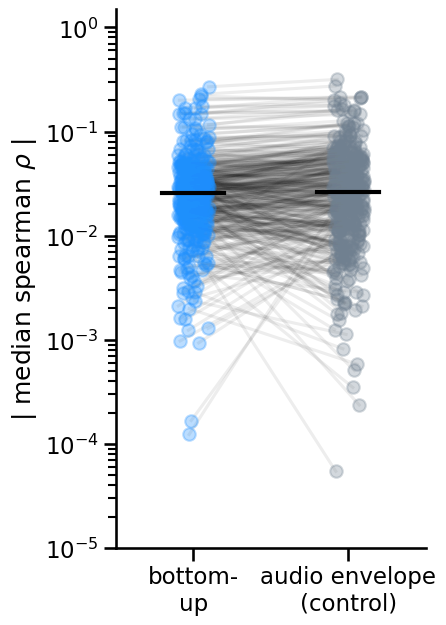

In [8]:
paired_rho_plot(btm_ctrl_df, 'raw_btm_rho', 'dodgerblue', 'bottom-\nup')

## panel C

This panel contains sEEG electrode location information, and these data are available upon reasonable request, subject to IRB approval.

In [ ]:
patients = ['1002', '1005', '1007', '1008', '1009', '1010', '1014']
SDids = ['SD021', 'SD026', 'SD027', 'SD028', 'SD029', 'SD030', 'SD035']


metrics = ['raw_top_rho']
hemis = ['left', 'right']
views = ['lateral']

for metric in metrics:
    for hemi in hemis:
        for view in views:
            plot_brain_model_fits(patients, SDids, metric=metric, hemi=hemi, view=view)

## panel D

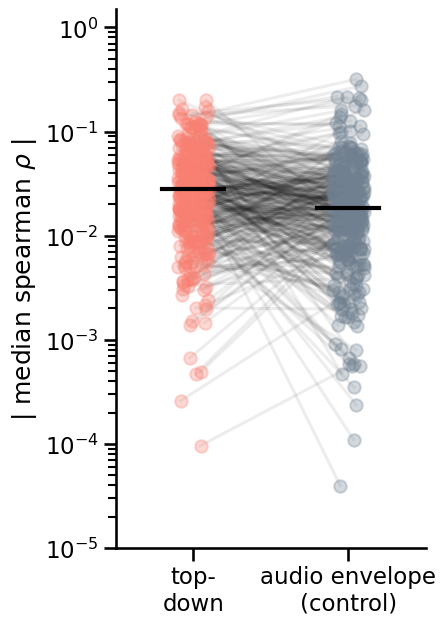

In [10]:
paired_rho_plot(td_ctrl_df, 'raw_top_rho', 'salmon', 'top-\ndown')

## panel E

This panel contains sEEG electrode location information, and these data are available upon reasonable request, subject to IRB approval.

In [ ]:
patients = ['1002', '1005', '1007', '1008', '1009', '1010', '1014']
SDids = ['SD021', 'SD026', 'SD027', 'SD028', 'SD029', 'SD030', 'SD035']


metrics = ['raw_SAM_y_rho',]
hemis = ['left', 'right']
views = ['lateral']

for metric in metrics:
    for hemi in hemis:
        for view in views:
            plot_brain_model_fits(patients, SDids, metric=metric, hemi=hemi, view=view)

## panel F


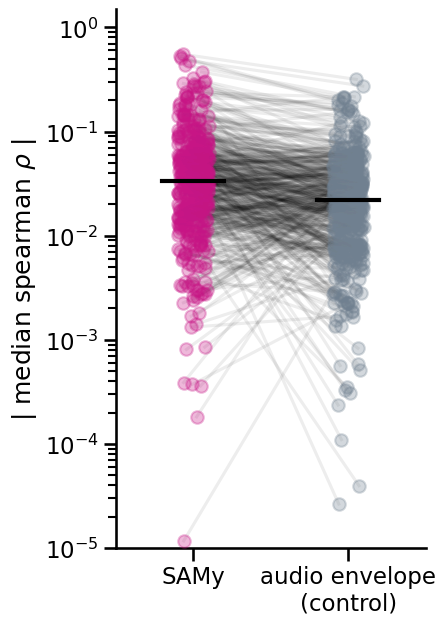

In [12]:
paired_rho_plot(sam_ctrl_df, 'raw_SAM_y_rho', 'mediumvioletred', 'SAMy')

## panel G

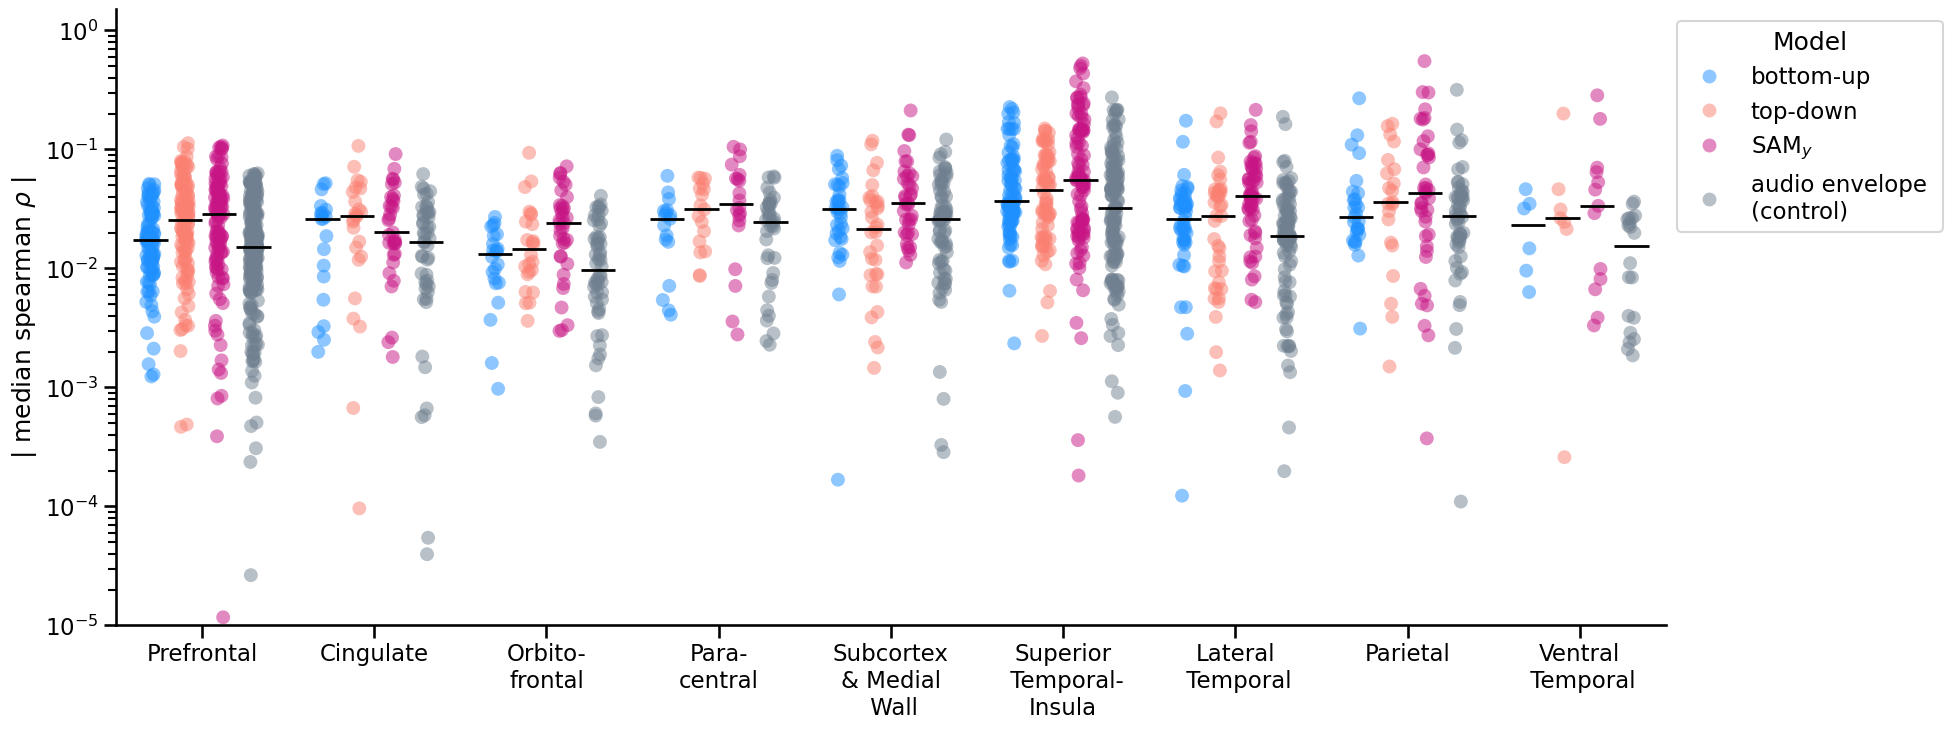

In [13]:
reorg_df = make_long_form(wide_form_df)
reorg_df_sig = reorg_df[reorg_df['pFDR']<0.001]

# drop rows from control model from channels that aren't significant for any model
# list of channels with significant rhos for other models
chans = reorg_df_sig[(reorg_df_sig['model']!='control_rho') &
                     (reorg_df_sig['pFDR']<0.001)]['channel'].unique()

reorg_df_sig_limctrl = reorg_df_sig[((reorg_df_sig['model']=='control_rho') & reorg_df_sig['channel'].isin(chans)) |
                                    (reorg_df_sig['model']=='raw_top_rho') |
                                    (reorg_df_sig['model']=='raw_btm_rho') |
                                    (reorg_df_sig['model']=='raw_SAM_y_rho')]

plot_regionwise_model_similarity(reorg_df_sig_limctrl)

### statistics

In [14]:
models = ['raw_top_rho', 'raw_btm_rho', 'raw_SAM_y_rho', 'control_rho']

for model in models:
    print(model + ' mean: ' + str(reorg_df_sig[reorg_df_sig['model']==model]['rho'].mean()))
    print(model + ' std: ' +  str(reorg_df_sig[reorg_df_sig['model']==model]['rho'].std()))

    Q1 = reorg_df_sig[reorg_df_sig['model']==model]['rho'].quantile(0.25)
    Q3 = reorg_df_sig[reorg_df_sig['model']==model]['rho'].quantile(0.75)
    
    print(model + ' IQR: ' +  str(Q3-Q1) + '\n')

raw_top_rho mean: 0.03745130617524893
raw_top_rho std: 0.034633518558893024
raw_top_rho IQR: 0.03652687842030058

raw_btm_rho mean: 0.03407815243835048
raw_btm_rho std: 0.036004609735991754
raw_btm_rho IQR: 0.023056542185046776

raw_SAM_y_rho mean: 0.05652557794892983
raw_SAM_y_rho std: 0.07461110985002532
raw_SAM_y_rho IQR: 0.044316337330614

control_rho mean: 0.026640157490999503
control_rho std: 0.03177047547820883
control_rho IQR: 0.02530131784021095



In [15]:
print('total # electrodes: '+str(len(reorg_df[reorg_df['model']=='raw_top_rho'])))
print('# top-down electrodes: ' + str(len(reorg_df_sig_limctrl[reorg_df_sig_limctrl['model']=='raw_top_rho'])))
print('# bottom-up electrodes: ' + str(len(reorg_df_sig_limctrl[reorg_df_sig_limctrl['model']=='raw_btm_rho'])))
print('# SAM electrodes: ' + str(len(reorg_df_sig_limctrl[reorg_df_sig_limctrl['model']=='raw_SAM_y_rho'])))

total # electrodes: 887
# top-down electrodes: 350
# bottom-up electrodes: 364
# SAM electrodes: 449


In [16]:
friedman(reorg_df_sig_limctrl, dv='rho', within='model', subject='subj')

,Source,W,ddof1,Q,p-unc
Friedman,model,0.477551,3,10.028571,0.018325


In [17]:
wilcoxon_list = []
pvals = []
tests = []

test = 'top_control'

x = td_ctrl_df['raw_top_rho']
y = td_ctrl_df['control_rho']

w = wilcoxon(x,y)
w['test'] = test
w['M1_electrodes'] = len(x)
w['M2_electrodes'] = len(y)
w['M1 Median'] = np.median(x)
w['M1 Q1'] = np.quantile(x, 0.25)
w['M1 Q3'] = np.quantile(x, 0.75)
w['M2 Median'] = np.median(y)
w['M2 Q1'] = np.quantile(y, 0.25)
w['M2 Q3'] = np.quantile(y, 0.75)
wilcoxon_list.append(w)
tests.append(test)

In [18]:
test = 'btm_control'

x = btm_ctrl_df['raw_btm_rho']
y = btm_ctrl_df['control_rho']

w = wilcoxon(x,y)
w['test'] = test
w['M1_electrodes'] = len(x)
w['M2_electrodes'] = len(y)
w['M1 Median'] = np.median(x)
w['M1 Q1'] = np.quantile(x, 0.25)
w['M1 Q3'] = np.quantile(x, 0.75)
w['M2 Median'] = np.median(y)
w['M2 Q1'] = np.quantile(y, 0.25)
w['M2 Q3'] = np.quantile(y, 0.75)
wilcoxon_list.append(w)
tests.append(test)

In [19]:
test = 'sam_control'

x = sam_ctrl_df['raw_SAM_y_rho']
y = sam_ctrl_df['control_rho']

w = wilcoxon(x,y)
w['test'] = test
w['M1_electrodes'] = len(x)
w['M2_electrodes'] = len(y)
w['M1 Median'] = np.median(x)
w['M1 Q1'] = np.quantile(x, 0.25)
w['M1 Q3'] = np.quantile(x, 0.75)
w['M2 Median'] = np.median(y)
w['M2 Q1'] = np.quantile(y, 0.25)
w['M2 Q3'] = np.quantile(y, 0.75)
wilcoxon_list.append(w)
tests.append(test)

In [20]:
wilcoxon_df = pd.concat(wilcoxon_list)

In [21]:
mwu_list = []

test = 'top_btm'

x = td_ctrl_df['raw_top_rho']
y = btm_ctrl_df['raw_btm_rho']

t = mwu(x,y)
t['test'] = test
t['M1_electrodes'] = len(x)
t['M2_electrodes'] = len(y)
t['M1 Median'] = np.median(x)
t['M1 Q1'] = np.quantile(x, 0.25)
t['M1 Q3'] = np.quantile(x, 0.75)
t['M2 Median'] = np.median(y)
t['M2 Q1'] = np.quantile(y, 0.25)
t['M2 Q3'] = np.quantile(y, 0.75)

mwu_list.append(t)

In [22]:
test = 'top_sam'

x = td_ctrl_df['raw_top_rho']
y = sam_ctrl_df['raw_SAM_y_rho']

t = mwu(x,y)
t['test'] = test
t['M1_electrodes'] = len(x)
t['M2_electrodes'] = len(y)
t['M1 Median'] = np.median(x)
t['M1 Q1'] = np.quantile(x, 0.25)
t['M1 Q3'] = np.quantile(x, 0.75)
t['M2 Median'] = np.median(y)
t['M2 Q1'] = np.quantile(y, 0.25)
t['M2 Q3'] = np.quantile(y, 0.75)
mwu_list.append(t)

In [23]:
test = 'sam_btm'

x = sam_ctrl_df['raw_SAM_y_rho']
y = btm_ctrl_df['raw_btm_rho']

t = mwu(x,y)
t['test'] = test
t['M1_electrodes'] = len(x)
t['M2_electrodes'] = len(y)
t['M1 Median'] = np.median(x)
t['M1 Q1'] = np.quantile(x, 0.25)
t['M1 Q3'] = np.quantile(x, 0.75)
t['M2 Median'] = np.median(y)
t['M2 Q1'] = np.quantile(y, 0.25)
t['M2 Q3'] = np.quantile(y, 0.75)
mwu_list.append(t)

In [24]:
mwu_df = pd.concat(mwu_list)
all_stats_df = pd.concat([wilcoxon_df, mwu_df])
all_stats_df['significant'], all_stats_df['p_corr'] = multicomp(all_stats_df['p-val'].values, method='Holm')
all_stats_df

,W-val,alternative,p-val,RBC,CLES,test,M1_electrodes,M2_electrodes,M1 Median,M1 Q1,M1 Q3,M2 Median,M2 Q1,M2 Q3,U-val,significant,p_corr
Wilcoxon,21687.0,two-sided,1.894368e-06,0.293871,0.601665,top_control,350,350,0.028227,0.013623,0.050150,0.018468,0.008095,0.034814,NaN,True,8.156146e-06
Wilcoxon,23583.0,two-sided,1.631229e-06,-0.289989,0.487539,btm_control,364,364,0.025653,0.014710,0.037767,0.026004,0.012134,0.048658,NaN,True,8.156146e-06
Wilcoxon,24463.0,two-sided,2.835227e-21,0.515704,0.621842,sam_control,449,449,0.033554,0.016804,0.061120,0.022184,0.009832,0.041017,NaN,True,1.701136e-20
MWU,NaN,two-sided,1.855433e-01,0.057268,0.528634,top_btm,350,364,0.028227,0.013623,0.050150,0.025653,0.014710,0.037767,67348.0,False,1.855433e-01
MWU,NaN,two-sided,1.333820e-03,-0.132179,0.433910,top_sam,350,449,0.028227,0.013623,0.050150,0.033554,0.016804,0.061120,68189.0,True,2.667640e-03
MWU,NaN,two-sided,1.641573e-06,0.195306,0.597653,sam_btm,449,364,0.033554,0.016804,0.061120,0.025653,0.014710,0.037767,97678.0,True,8.156146e-06


In [25]:
region_order = ['Prefrontal', 'Cingulate', 'Orbitofrontal',  'Rolandic',
                    'MedialWall', 'SuperiorTemporal-Insula', 'LateralTemporal',
                    'Parietal', 'VentralTemporal']

In [26]:
# Regionwise Wilcoxon tests

models_compared = ['top_control', 'btm_control', 'sam_control']
metrics_compared = [['raw_top_rho', 'control_rho'], ['raw_btm_rho', 'control_rho'], ['raw_SAM_y_rho', 'control_rho']]
cols = ['region', 'models compared', 'M1 electrodes', 'M2 electrodes', 'test', 'test statistic', 'p-unc'] # add p-corr after FDR 

#sig_regions = ['Prefrontal', 'SuperiorTemporal-Insula']
w_list = []

for region in region_order:
    
    # get region dataframe
    region_df = all_ctrl_df[all_ctrl_df['X10']==region]

    for model, metrics in zip(models_compared, metrics_compared):

        if model == 'top_control':
            df = region_df[(region_df['raw_top_rho_pFDR']<0.001)]
        if model == 'btm_control':
            df = region_df[(region_df['raw_btm_rho_pFDR']<0.001)]
        if model == 'sam_control':
            df = region_df[(region_df['raw_SAM_y_rho_pFDR']<0.001)]
        
        x = df[metrics[0]]
        y = df[metrics[1]]

        w = wilcoxon(x,y)
        w['region'] = region
        w['models compared'] = model
        w['M1 electrodes'] = len(x)
        w['M2 electrodes'] = len(y)
        w['M1 median'] = np.median(x)
        w['M1 Q1'] = np.quantile(x,0.25)
        w['M1 Q3'] = np.quantile(x,0.75)
        w['M2 median'] = np.median(y)
        w['M2 Q1'] = np.quantile(y,0.25)
        w['M2 Q3'] = np.quantile(y,0.75)        

        w_list.append(w)

w_df = pd.concat(w_list)

w_df = w_df.reset_index()


# Mann-Whitney U-tests
models_compared = ['top_btm', 'btm_sam', 'sam_top']
metrics_compared = [['raw_top_rho', 'raw_btm_rho'], ['raw_btm_rho', 'raw_SAM_y_rho'], ['raw_SAM_y_rho', 'raw_top_rho']]

m_list = []

for region in region_order:
    
    # get region dataframe
    region_df = all_ctrl_df[all_ctrl_df['X10']==region]

    for model, metrics in zip(models_compared, metrics_compared):
        
        x = region_df[region_df[metrics[0]+'_pFDR']<0.001][metrics[0]]
        y = region_df[region_df[metrics[1]+'_pFDR']<0.001][metrics[1]]

        m = mwu(x,y)
        m['region'] = region
        m['models compared'] = model
        m['M1 electrodes'] = len(x)
        m['M2 electrodes'] = len(y)
        m['M1 median'] = np.median(x)
        m['M1 Q1'] = np.quantile(x,0.25)
        m['M1 Q3'] = np.quantile(x,0.75)
        m['M2 median'] = np.median(y)
        m['M2 Q1'] = np.quantile(y,0.25)
        m['M2 Q3'] = np.quantile(y,0.75) 

        m_list.append(m)

m_df = pd.concat(m_list)
m_df = m_df.reset_index()

stats_df = pd.concat([m_df, w_df])
stats_df['p_corr'] = multicomp(stats_df['p-val'].values, method='holm')[1]
stats_df['significant'] = multicomp(stats_df['p-val'].values, method='holm')[0]
stats_df

,index,U-val,alternative,p-val,RBC,CLES,region,models compared,M1 electrodes,M2 electrodes,M1 median,M1 Q1,M1 Q3,M2 median,M2 Q1,M2 Q3,W-val,p_corr,significant
0,MWU,7245.0,two-sided,9.507916e-04,0.261755,0.630878,Prefrontal,top_btm,116,99,0.025297,0.013622,0.045632,0.017317,0.010329,0.028999,NaN,0.043736,True
1,MWU,4275.0,two-sided,1.704331e-03,-0.249012,0.375494,Prefrontal,btm_sam,99,115,0.017317,0.010329,0.028999,0.028389,0.012138,0.045442,NaN,0.074991,False
2,MWU,6646.0,two-sided,9.630919e-01,-0.003598,0.498201,Prefrontal,sam_top,115,116,0.028389,0.012138,0.045442,0.025297,0.013622,0.045632,NaN,1.000000,False
3,MWU,288.0,two-sided,3.916879e-01,0.152000,0.576000,Cingulate,top_btm,25,20,0.027415,0.012583,0.043965,0.026079,0.007769,0.029797,NaN,1.000000,False
4,MWU,285.0,two-sided,4.141867e-01,-0.136364,0.431818,Cingulate,btm_sam,20,33,0.026079,0.007769,0.029797,0.020080,0.013249,0.038362,NaN,1.000000,False
5,MWU,403.0,two-sided,8.876232e-01,-0.023030,0.488485,Cingulate,sam_top,33,25,0.020080,0.013249,0.038362,0.027415,0.012583,0.043965,NaN,1.000000,False
6,MWU,315.0,two-sided,2.667863e-01,0.193182,0.596591,Orbitofrontal,top_btm,24,22,0.014500,0.009226,0.025609,0.013181,0.007747,0.018160,NaN,1.000000,False
7,MWU,208.0,two-sided,2.658297e-03,-0.474747,0.262626,Orbitofrontal,btm_sam,22,36,0.013181,0.007747,0.018160,0.024004,0.012639,0.033711,NaN,0.114307,False
8,MWU,545.0,two-sided,8.959363e-02,0.261574,0.630787,Orbitofrontal,sam_top,36,24,0.024004,0.012639,0.033711,0.014500,0.009226,0.025609,NaN,1.000000,False
9,MWU,184.0,two-sided,1.791756e-01,0.273356,0.636678,Rolandic,top_btm,17,17,0.031365,0.016868,0.046917,0.026120,0.016721,0.030370,NaN,1.000000,False
